In [1]:
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import torch.nn.functional as F

manualSeed = 999

print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

Random Seed:  999


In [4]:
!unzip 'archive.zip'

unzip:  cannot find or open archive.zip, archive.zip.zip or archive.zip.ZIP.


In [3]:

dataroot = "/kaggle/input/covid19-image-dataset/Covid19-dataset/train"


workers = 2


batch_size = 64
    

image_size = 64


nc = 3


nz = 100


ngf = 64


ndf = 64


num_epochs = 500


lr = 0.0001


beta1 = 0.5


ngpu = 1

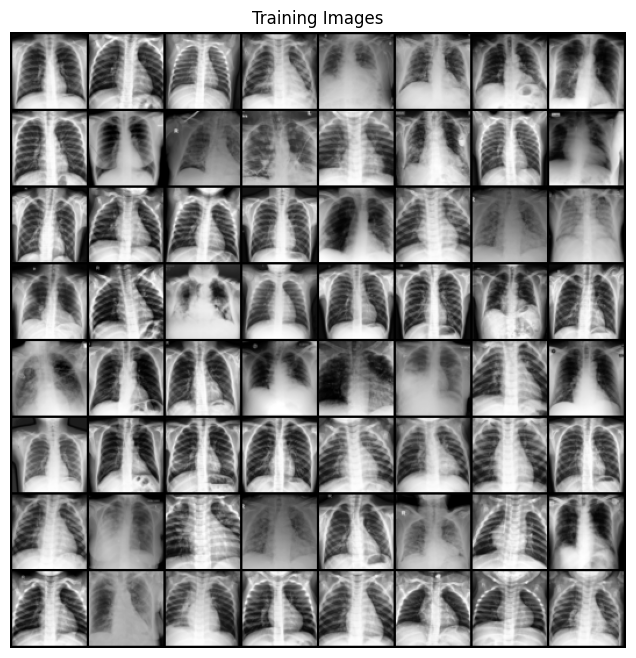

In [4]:

dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [5]:

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [6]:

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
             
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            
        )

    def forward(self, input):
        f = self.main(input)
        #print(f.shape)
        return f

In [9]:

netG = Generator(ngpu).to(device)


if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))


netG.apply(weights_init)


print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [10]:
# class Discriminator(nn.Module):
#     def __init__(self, ngpu):
#         super(Discriminator, self).__init__()
#         self.ngpu = ngpu
#         self.main = nn.Sequential(
#             # input is ``(nc) x 64 x 64``
#             nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. ``(ndf) x 32 x 32``
#             nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ndf * 2),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. ``(ndf*2) x 16 x 16``
#             nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ndf * 4),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. ``(ndf*4) x 8 x 8``
#             nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ndf * 8),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. ``(ndf*8) x 4 x 4``
#             nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
#             nn.Sigmoid()
#         )

#     def forward(self, input):
#         return self.main(input)

# Define U-Net Block
class UNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=4, stride=2, padding=1, normalize=True):
        super(UNetBlock, self).__init__()
        layers = []
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False))
        if normalize:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


class UNetDiscriminator(nn.Module):
    def __init__(self, in_channels, ngpu):
        super(UNetDiscriminator, self).__init__()
        self.ngpu = ngpu
        self.down1 = UNetBlock(in_channels, 64, normalize=False)
        self.down2 = UNetBlock(64, 128)
        self.down3 = UNetBlock(128, 256)
        self.down4 = UNetBlock(256, 512, normalize=False)
        self.final = nn.Conv2d(512, 1, 4, 1, 0, bias=False)

    def forward(self, x):
        x1 = self.down1(x)
        x2 = self.down2(x1)
        x3 = self.down3(x2)
        x4 = self.down4(x3)
        output = self.final(x4)
        #print(output.shape)
        s = F.sigmoid(output)
        #print(s.shape)
        return s


In [11]:

netD = UNetDiscriminator(nc, ngpu).to(device)


if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))


netD.apply(weights_init)

# Print the model
print(netD)

UNetDiscriminator(
  (down1): UNetBlock(
    (model): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
  )
  (down2): UNetBlock(
    (model): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
  )
  (down3): UNetBlock(
    (model): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
  )
  (down4): UNetBlock(
    (model): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)

In [12]:

criterion = nn.BCELoss()


fixed_noise = torch.randn(64, nz, 1, 1, device=device)


real_label = 1.
fake_label = 0.


optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [13]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        
        netD.zero_grad()
        
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        
        output = netD(real_cpu).view(-1)
        
        errD_real = criterion(output, label)
        
        errD_real.backward()
        D_x = output.mean().item()

        
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        
        fake = netG(noise)
        label.fill_(fake_label)
        
        output = netD(fake.detach()).view(-1)
        
        errD_fake = criterion(output, label)
        
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        
        errD = errD_real + errD_fake
        
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        
        output = netD(fake).view(-1)
        
        errG = criterion(output, label)
        
        errG.backward()
        D_G_z2 = output.mean().item()
        
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/500][0/4]	Loss_D: 1.7926	Loss_G: 1.8550	D(x): 0.4241	D(G(z)): 0.5232 / 0.1890
[1/500][0/4]	Loss_D: 0.2069	Loss_G: 4.4994	D(x): 0.9253	D(G(z)): 0.1080 / 0.0152
[2/500][0/4]	Loss_D: 0.1850	Loss_G: 4.7280	D(x): 0.9678	D(G(z)): 0.1343 / 0.0122
[3/500][0/4]	Loss_D: 0.1370	Loss_G: 5.1679	D(x): 0.9729	D(G(z)): 0.0980 / 0.0075
[4/500][0/4]	Loss_D: 0.0994	Loss_G: 5.4374	D(x): 0.9712	D(G(z)): 0.0601 / 0.0062
[5/500][0/4]	Loss_D: 0.1108	Loss_G: 5.6631	D(x): 0.9499	D(G(z)): 0.0427 / 0.0048
[6/500][0/4]	Loss_D: 0.0763	Loss_G: 5.7476	D(x): 0.9790	D(G(z)): 0.0502 / 0.0043
[7/500][0/4]	Loss_D: 0.0733	Loss_G: 6.4532	D(x): 0.9800	D(G(z)): 0.0491 / 0.0023
[8/500][0/4]	Loss_D: 0.0543	Loss_G: 6.3272	D(x): 0.9786	D(G(z)): 0.0299 / 0.0024
[9/500][0/4]	Loss_D: 0.0504	Loss_G: 6.3098	D(x): 0.9805	D(G(z)): 0.0285 / 0.0027
[10/500][0/4]	Loss_D: 0.0606	Loss_G: 6.2765	D(x): 0.9721	D(G(z)): 0.0290 / 0.0024
[11/500][0/4]	Loss_D: 0.0408	Loss_G: 6.4785	D(x): 0.9865	D(G(z)): 0.0261 / 0.0023


In [14]:
np.savez('64_0.0001_gLOSS_500',G_losses),np.savez('64_0.0001_DLOSS_500',D_losses)

(None, None)

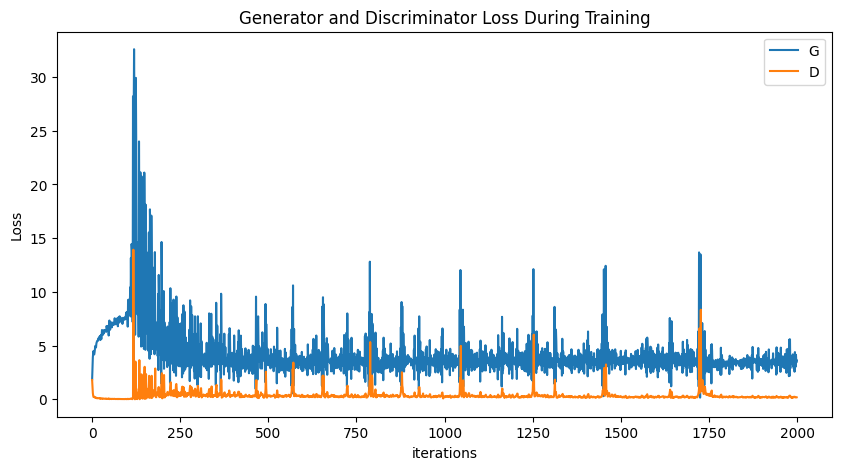

In [15]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

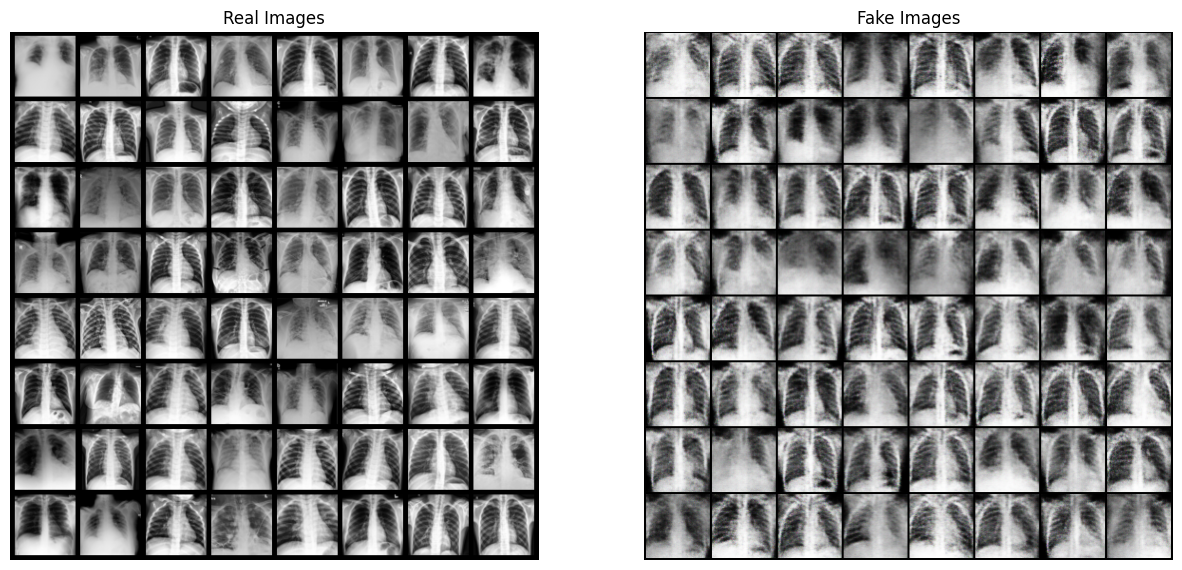

In [17]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [18]:
torch.save(netG.state_dict(), f'generator_{lr}_{batch_size}_{num_epochs}.pth')
torch.save(netD.state_dict(), f'discriminator_{lr}_{batch_size}_{num_epochs}.pth')

In [53]:
model = Generator(ngpu)
model.load_state_dict(torch.load('/kaggle/input/z/pytorch/dasdg/1/generator_0.0001_64_500.pth'))

<All keys matched successfully>

In [48]:
noise = torch.randn(64, nz, 1, 1, device='cpu')
output = model(noise)
type(output)

torch.Tensor

In [42]:
#plt.imshow(output)
numpy_array = output.detach().numpy()
final_arr = []

for i in numpy_array:
    final_arr.append(np.rot90(np.transpose(numpy_array[0]),-1))
final_arr = np.array(final_arr)

In [67]:
import cv2

%matplotlib inline 
count = 0
for img in final_arr:
    count+=1
    #cv2.imwrite(f'/kaggle/working/generated_{count}.png', img)
    os.remove(f"/kaggle/working/generated_{count}.png")

In [65]:

def inception_score(images, batch_size=64, splits=10):
    
    inception_model = models.inception_v3(pretrained=True, transform_input=False, aux_logits=True).cuda()
    inception_model.eval()
    up = nn.Upsample(size=(299, 299), mode='bilinear', align_corners=False).cuda()

    
    transform = transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    
    fake_dataset = ImageFolder(root=images, transform=transform)
    fake_loader = DataLoader(fake_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    preds = []
    with torch.no_grad():
        for batch in tqdm(fake_loader, desc='Calculating Inception Score'):
            batch = batch[0].cuda()
            batch = up(batch)
            pred = inception_model(batch)
            preds.append(F.softmax(pred, dim=1).cpu().numpy())

    preds = np.concatenate(preds, axis=0)

    
    scores = []
    for i in range(splits):
        part = preds[i * (preds.shape[0] // splits): (i + 1) * (preds.shape[0] // splits), :]
        kl = part * (np.log(part) - np.log(np.expand_dims(np.mean(part, 0), 0)))
        kl = np.mean(np.sum(kl, 1))
        scores.append(np.exp(kl))

    return np.mean(scores), np.std(scores)

In [ ]:
def generate_and_save_fake_images_to_classes(generator, num_images_per_class, class_labels, save_dir):
    generator.eval()
    os.makedirs(save_dir, exist_ok=True)
    for label in class_labels:
        class_dir = os.path.join(save_dir, str(label))
        os.makedirs(class_dir, exist_ok=True)
        for i in range(num_images_per_class):
            with torch.no_grad():
                noise = torch.randn(1, nz, 1, 1, device=device)
                fake = generator(noise).detach().cpu()
            vutils.save_image(fake, os.path.join(class_dir, f'fake_image_{label}_{i+1:04d}.png'), normalize=True)
class_labels = ['Covid', 'Normal', 'Viral Pneumonia']  # Assuming you have 3 classes

netG = Generator(ngpu).to(device)
netG.load_state_dict(torch.load("/kaggle/input/z/pytorch/dasdg/1/generator_0.0001_64_500.pth"))

generate_and_save_fake_images_to_classes(model, 250, class_labels, "/kaggle/working/fake_images_per_class")